# Obesity prediction using Machine Learning 

# Import Libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
np.random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
import joblib
from joblib import dump, load
import os
import pickle
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier # Boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier   # Stacking
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px


In [2]:
#read csv file 
df= pd.read_csv('modified_data.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Classes
0,Female,21.0,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,24.39,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,24.24,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,23.77,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,26.85,Overweight
4,Male,22.0,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,28.34,Overweight


In [3]:
#create x and y 
features=df.drop('Classes',axis=1)
target=df['Classes']

# Data Preprocessing

In [4]:
#Create a pipline 
s = StandardScaler()
ohe = OneHotEncoder()
cat_features = features.select_dtypes('object').columns.tolist()

# Remove CALC and CAEC from the cat_features since they'll be ordinal encoded
for feature in ['CALC', 'CAEC']:
    if feature in cat_features:
        cat_features.remove(feature)

no_change_features = ['NCP','FCVC', 'CH2O', 'TUE','FAF']
num_features = ['Age', 'Height', 'Weight','BMI']
num_transformer = Pipeline(steps=[
    ('scaling', s)
])
cat_transformer = Pipeline(steps=[
    ('onehot', ohe)
])
# Ordinal transformer
calc_order = ['no', 'Sometimes', 'Frequently','Always']
caec_order = ['no', 'Sometimes', 'Frequently','Always']
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[calc_order, caec_order]))
])
# Updated ColumnTransformer to include the ordinal transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),  # other categorical features
        ('ordinal', ordinal_transformer, ['CALC', 'CAEC']),
        ('pass_through', 'passthrough', no_change_features)
    ])
# Full pipeline: preprocessing + model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])



In [5]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling',
                                                  StandardScaler())]),
                                 ['Age', 'Height', 'Weight', 'BMI']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always'],
                                                                             ['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']]))]),
                                 ['CALC', 'CAEC']),
                                ('pass_through', 'passthrough',
                                 ['NCP', 'FCVC', 'CH2O', 'TUE', 'FAF'])])

In [6]:
#split the data

features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)
#Fit and transform the data
X_transformed = preprocessor.fit_transform(features_train)

#Extract feature names
feature_names = []

# For one-hot encoded features
for transformer_name, transformer, columns in preprocessor.transformers_:
    if transformer_name == 'cat':
        # Get one-hot feature names
        feature_names.extend(list(transformer.named_steps['onehot'].get_feature_names_out(columns)))

    elif transformer_name == 'ordinal':
        feature_names.extend(columns)  

    elif transformer_name == 'pass_through' or transformer_name == 'num':
        feature_names.extend(columns)  

#Convert to DataFrame
transformed_df = pd.DataFrame(X_transformed, columns=feature_names)


# Ordinal encode the target_train
order = [['Insufficient_Weight', 'Normal_Weight', 'Overweight', 
          'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']]
encoder = OrdinalEncoder(categories=order)
y_encoded = encoder.fit_transform(target_train.values.reshape(-1, 1))

# Convert y_encoded to DataFrame and reset its index to match transformed_df
y_df = pd.DataFrame(y_encoded, columns=['Classes'])
y_df.reset_index(drop=True, inplace=True)

# Reset index of transformed_df to ensure the concatenation goes smoothly
transformed_df.reset_index(drop=True, inplace=True)

# Add the encoded Classes column to the transformed dataframe
transformed_df['Classes'] = y_df

transformed_df.head()



,Age,Height,Weight,BMI,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,...,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC,NCP,FCVC,CH2O,TUE,FAF,Classes
0,-0.701820,0.446696,-1.209716,-1.446416,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,0.0
1,0.289064,-0.647718,0.956816,1.458557,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,5.0
2,-0.117564,0.004151,-0.443484,-0.476434,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0
3,0.208967,1.970783,1.322149,0.548266,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,0.0,1.0,3.0
4,-0.190323,-0.882487,-1.092430,-0.945259,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0


In [7]:

correlation_matrix = transformed_df.corr()
correlation_matrix


,Age,Height,Weight,BMI,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,...,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC,NCP,FCVC,CH2O,TUE,FAF,Classes
Age,1.000000,-0.017874,0.208068,0.244884,-0.039534,0.039534,-0.195730,0.195730,-0.050599,0.050599,...,-0.537855,-0.057946,0.046196,-0.083200,-0.014911,0.011738,-0.026180,-0.218639,-0.140833,0.252863
Height,-0.017874,1.000000,0.456958,0.125331,-0.617329,0.617329,-0.247813,0.247813,-0.193122,0.193122,...,-0.101987,0.047186,0.137647,-0.041570,0.213976,-0.045455,0.174468,-0.008655,0.225475,0.120220
Weight,0.208068,0.456958,1.000000,0.934977,-0.161445,0.161445,-0.489834,0.489834,-0.276313,0.276313,...,0.056569,-0.100642,0.204125,-0.283779,0.182067,0.170723,0.164882,-0.257663,-0.094901,0.915798
BMI,0.244884,0.125331,0.934977,1.000000,0.051973,-0.051973,-0.473437,0.473437,-0.246277,0.246277,...,0.090476,-0.127654,0.164370,-0.310090,0.128085,0.217483,0.120781,-0.283334,-0.192314,0.982409
Gender_Female,-0.039534,-0.617329,-0.161445,0.051973,1.000000,-1.000000,0.097960,-0.097960,0.074742,-0.074742,...,0.152076,-0.045822,0.005772,0.084356,-0.032097,0.262753,-0.086647,-0.092718,-0.153718,0.053453
Gender_Male,0.039534,0.617329,0.161445,-0.051973,-1.000000,1.000000,-0.097960,0.097960,-0.074742,0.074742,...,-0.152076,0.045822,-0.005772,-0.084356,0.032097,-0.262753,0.086647,0.092718,0.153718,-0.053453
family_history_with_overweight_no,-0.195730,-0.247813,-0.489834,-0.473437,0.097960,-0.097960,1.000000,-1.000000,0.205826,-0.205826,...,0.062504,0.046081,0.044594,0.168040,-0.098022,-0.025996,-0.139575,0.063059,0.062233,-0.470234
family_history_with_overweight_yes,0.195730,0.247813,0.489834,0.473437,-0.097960,0.097960,-1.000000,1.000000,-0.205826,0.205826,...,-0.062504,-0.046081,-0.044594,-0.168040,0.098022,0.025996,0.139575,-0.063059,-0.062233,0.470234
FAVC_no,-0.050599,-0.193122,-0.276313,-0.246277,0.074742,-0.074742,0.205826,-0.205826,1.000000,-1.000000,...,-0.036181,0.175924,-0.077622,0.162583,-0.018450,0.059983,-0.007200,-0.004968,0.112826,-0.259017
FAVC_yes,0.050599,0.193122,0.276313,0.246277,-0.074742,0.074742,-0.205826,0.205826,-1.000000,1.000000,...,0.036181,-0.175924,0.077622,-0.162583,0.018450,-0.059983,0.007200,0.004968,-0.112826,0.259017


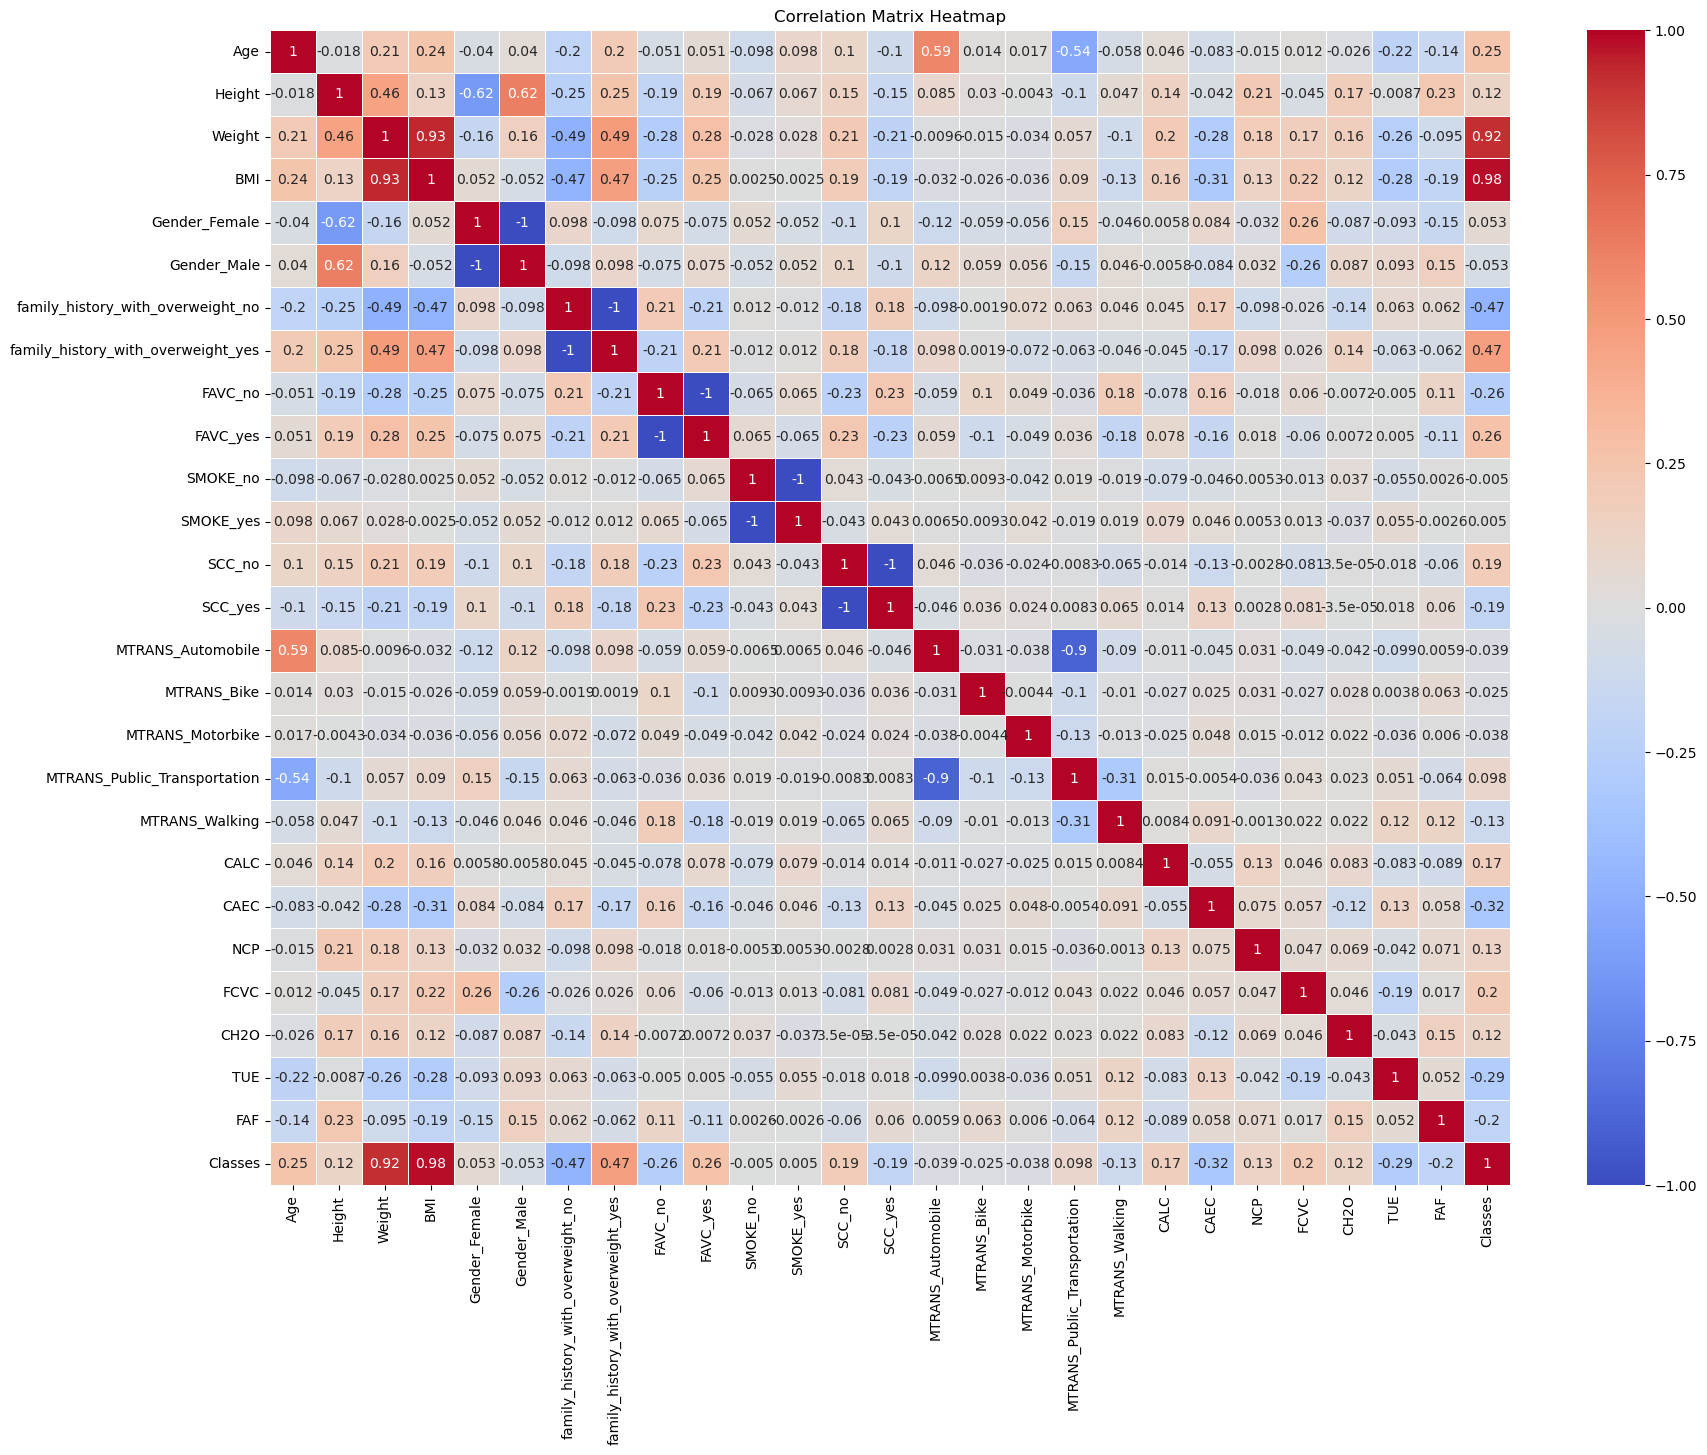

In [8]:
#plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [9]:
# multicollinearity
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

vif = calculate_vif(transformed_df)
print(vif)
while vif["VIF"].max() > 10:
    remove = vif.sort_values("VIF", ascending=False).iloc[0]
    if remove["Feature"] in df.columns:
        df.drop(remove["Feature"], axis=1, inplace=True)
        vif = calculate_vif(transformed_df)
    else:
        print(f"Column {remove['Feature']} not found in dataframe.")
        break

                               Feature         VIF
0                                  Age    1.912899
1                               Height   19.737120
2                               Weight  135.412064
3                                  BMI  152.911227
4                        Gender_Female         inf
5                          Gender_Male         inf
6    family_history_with_overweight_no         inf
7   family_history_with_overweight_yes         inf
8                              FAVC_no         inf
9                             FAVC_yes         inf
10                            SMOKE_no         inf
11                           SMOKE_yes         inf
12                              SCC_no         inf
13                             SCC_yes         inf
14                   MTRANS_Automobile         inf
15                         MTRANS_Bike         inf
16                    MTRANS_Motorbike         inf
17        MTRANS_Public_Transportation         inf
18                      MTRANS_

In [11]:
transformed_df.head()

,Age,Height,Weight,BMI,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,...,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC,NCP,FCVC,CH2O,TUE,FAF,Classes
0,-0.701820,0.446696,-1.209716,-1.446416,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,0.0
1,0.289064,-0.647718,0.956816,1.458557,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,5.0
2,-0.117564,0.004151,-0.443484,-0.476434,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0
3,0.208967,1.970783,1.322149,0.548266,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,0.0,1.0,3.0
4,-0.190323,-0.882487,-1.092430,-0.945259,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0


In [12]:
transformed_df.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'Gender_Female', 'Gender_Male',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'SMOKE_no',
       'SMOKE_yes', 'SCC_no', 'SCC_yes', 'MTRANS_Automobile', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking',
       'CALC', 'CAEC', 'NCP', 'FCVC', 'CH2O', 'TUE', 'FAF', 'Classes'],
      dtype='object')

In [13]:
#split the data
features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)

def ml_preprocess(df):
    
    features = df.drop('Classes',axis=1)
    target=df['Classes']
    return features, target


In [14]:
features, target = ml_preprocess(df)


# Machine Learning Models

# **Logistic Regression**

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. 

In [15]:
#Since the label is 6 classes so its multinomial 
lr = LogisticRegression(multi_class='multinomial', max_iter=1000)

model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', lr)
])


In [16]:
model_pipeline_lr.fit(features, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

***Hyperparemeter tunning*** 

In [17]:
# Iterate over the C values as hyperparameters for regularization strength in logistic regression
for C_value in [0.1, 1, 10, 100, 1000]:
    
    model_pipeline_lr.set_params(clf__C=C_value)  # Setting the C value for the Logistic Regression in the pipeline
    
    model_pipeline_lr.fit(features_train, target_train)
    
    predicted_train = model_pipeline_lr.predict(features_train)
    predicted_test = model_pipeline_lr.predict(features_test)
    
    print('C Value', C_value)
    
    # Accuracy for training set
    train_accuracy = accuracy_score(target_train, predicted_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    
    # Accuracy for test set
    test_accuracy = accuracy_score(target_test, predicted_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report for test set
    print(classification_report(target_test, predicted_test))
    print('------------------------------------------------')


C Value 0.1
Train Accuracy: 0.8697
Test Accuracy: 0.8511
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.94      0.93        54
      Normal_Weight       0.86      0.62      0.72        60
     Obesity_Type_I       0.92      0.74      0.82        74
    Obesity_Type_II       0.87      0.87      0.87        68
   Obesity_Type_III       0.87      0.96      0.91        54
         Overweight       0.78      0.94      0.85       113

           accuracy                           0.85       423
          macro avg       0.87      0.85      0.85       423
       weighted avg       0.86      0.85      0.85       423

------------------------------------------------
C Value 1
Train Accuracy: 0.9336
Test Accuracy: 0.9291
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.94      0.94        54
      Normal_Weight       0.93      0.85      0.89        60
     Obesity_Type_I       0.93      0.93  

In [18]:

features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42)
# Define the path to your model
model_path = "logistic_regression_model.pkl"

# Check if the model file exists
if os.path.exists(model_path):
    # Load the model
    with open(model_path, 'rb') as file:
        model_pipeline_lr = pickle.load(file)
    print("Model loaded successfully!")

else:
     # Train the model if it doesn't exist
    model_pipeline_lr.fit(features_train, target_train)

    # Save the trained model
    with open(model_path, 'wb') as file:
        pickle.dump(model_pipeline_lr, file)
        print("Model trained and saved successfully!")

# Predict on training data to get training accuracy
train_predictions = model_pipeline_lr.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Predict on test data to get test accuracy
predicted_targets = model_pipeline_lr.predict(features_test)
test_accuracy_lr = accuracy_score(target_test, predicted_targets)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get the classification report
report = classification_report(target_test, predicted_targets)
print("Classification Report:")
print(report)



Model loaded successfully!
Training Accuracy: 99.88%
Test Accuracy: 98.11%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.98      0.95        54
      Normal_Weight       0.98      0.93      0.95        67
     Obesity_Type_I       0.98      0.99      0.98        83
    Obesity_Type_II       0.94      0.97      0.95        60
   Obesity_Type_III       1.00      0.95      0.97        58
         Overweight       1.00      1.00      1.00       101

           accuracy                           0.97       423
          macro avg       0.97      0.97      0.97       423
       weighted avg       0.97      0.97      0.97       423




Confusion Matrix:
[[ 53   1   0   0   0   0]
 [  5  62   0   0   0   0]
 [  0   0  82   1   0   0]
 [  0   0   2  58   0   0]
 [  0   0   0   3  55   0]
 [  0   0   0   0   0 101]]


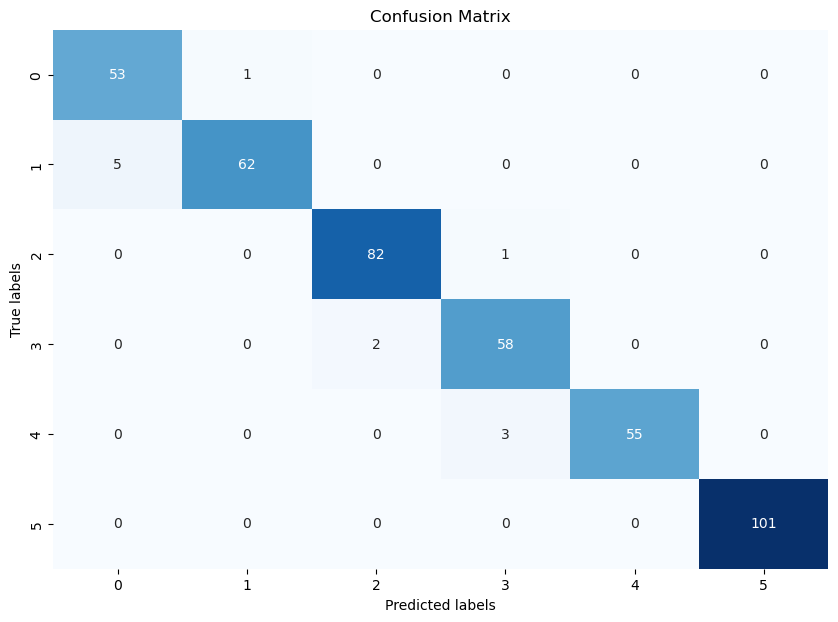

In [19]:
# Get the confusion matrix
conf_matrix = confusion_matrix(target_test, predicted_targets)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='Blues', cbar=False)  # fmt="g" ensures numbers are displayed as integers
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**Preprocessing For Tree Based Models**

In [20]:
#we don't need StandardScaler for random forests, so we'll remove that.

cat_transformer_no_scaling = Pipeline(steps=[
    ('onehot', ohe)
])

num_transformer_no_scaling = 'passthrough'  # No scaling required

# Updated ColumnTransformer for tree-based models
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_transformer_no_scaling, num_features),
        ('cat', cat_transformer_no_scaling, cat_features),
        ('ordinal', ordinal_transformer, ['CALC', 'CAEC']),
        ('pass_through', 'passthrough', no_change_features)
    ])
# Full pipeline: preprocessing + model
full_pipeline = Pipeline(steps=[
    ('preprocessor2', preprocessor2)
])



In [21]:
preprocessor2

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['Age', 'Height', 'Weight', 'BMI']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always'],
                                                                             ['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']]))]),
                                 ['CALC', 'CAEC']),
                                ('pass_through', 'passthrough',
                                 ['NCP', 'FCVC', 'CH2O', 'TUE', 'FAF'])])

# Random Forest

Random forest (RF) is an ensemble learning classification and regression method suitable for handling problems involving grouping of data into classes. The algorithm was developed by Breiman and Cutler. In RF, prediction is achieved using decision trees. During the training phase, a number of decision trees are constructed which are then used for the class prediction; this is achieved by considering the voted classes of all the individual trees and the class with the highest vote is considered to be the output.

In [22]:

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Create the pipeline
model_pipeline_RF = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('clf', rf_clf)
])

# Fit the pipeline to the training data
model_pipeline_RF.fit(features_train, target_train)



Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [23]:
# Creating a pipeline for RandomForest
model_pipeline_RF = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('clf', RandomForestClassifier(random_state=42))
])

# Iterate over possible n_estimators values for the RandomForest
for n_trees in [10, 50, 100, 150, 200]:
    
    # Setting the n_estimators for the RandomForest in the pipeline
    model_pipeline_RF.set_params(clf__n_estimators=n_trees)
    
    # Fit the model using training data
    model_pipeline_RF.fit(features_train, target_train)
    
    # Predictions for training and test set
    predicted_train = model_pipeline_RF.predict(features_train)
    predicted_test = model_pipeline_RF.predict(features_test)
    
    print('Number of Trees:', n_trees)
    
    # Accuracy for training set
    train_accuracy = accuracy_score(target_train, predicted_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    
    # Accuracy for test set
    test_accuracy = accuracy_score(target_test, predicted_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report for test set
    print(classification_report(target_test, predicted_test))
    print('------------------------------------------------')


Number of Trees: 10
Train Accuracy: 0.9994
Test Accuracy: 0.9811
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.96      0.95        54
      Normal_Weight       0.97      0.94      0.95        67
     Obesity_Type_I       0.98      1.00      0.99        83
    Obesity_Type_II       1.00      0.97      0.98        60
   Obesity_Type_III       1.00      1.00      1.00        58
         Overweight       0.99      1.00      1.00       101

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      0.98      0.98       423

------------------------------------------------
Number of Trees: 50
Train Accuracy: 1.0000
Test Accuracy: 0.9929
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.98      0.98        54
      Normal_Weight       0.99      0.99      0.99        67
     Obesity_Type_I     

In [24]:
# Define the path for Random Forest model
model_path_RF = "random_forest_model.pkl"

# Check if the model file exists
if os.path.exists(model_path_RF):
    # Load the model
    with open(model_path_RF, 'rb') as file:
        model_pipeline_RF = pickle.load(file)
    print("Model loaded successfully!")
else:
    # Train the model if it doesn't exist
    model_pipeline_RF.fit(features_train, target_train)

    # Save the trained model
    with open(model_path_RF, 'wb') as file:
        pickle.dump(model_pipeline_RF, file)
    print("Model trained and saved successfully!")


# Predict on training data to get training accuracy
train_predictions_RF = model_pipeline_RF.predict(features_train)
train_accuracy_RF = accuracy_score(target_train, train_predictions_RF)
print(f"Training Accuracy: {train_accuracy_RF * 100:.2f}%")

# Predict on test data to get test accuracy
test_predictions_RF = model_pipeline_RF.predict(features_test)
test_accuracy_RF = accuracy_score(target_test, test_predictions_RF)
print(f"Test Accuracy: {test_accuracy_RF * 100:.2f}%")

# Get the classification report for Random Forest
report_RF = classification_report(target_test, test_predictions_RF)
print("Classification Report:")
print(report_RF)

# Get the confusion matrix for Random Forest
conf_matrix_RF = confusion_matrix(target_test, test_predictions_RF)
print("\nConfusion Matrix:")
print(conf_matrix_RF)


Model loaded successfully!
Training Accuracy: 100.00%
Test Accuracy: 99.29%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      1.00      0.98        54
      Normal_Weight       1.00      0.97      0.98        67
     Obesity_Type_I       0.99      1.00      0.99        83
    Obesity_Type_II       1.00      0.98      0.99        60
   Obesity_Type_III       1.00      1.00      1.00        58
         Overweight       1.00      1.00      1.00       101

           accuracy                           0.99       423
          macro avg       0.99      0.99      0.99       423
       weighted avg       0.99      0.99      0.99       423


Confusion Matrix:
[[ 54   0   0   0   0   0]
 [  2  65   0   0   0   0]
 [  0   0  83   0   0   0]
 [  0   0   1  59   0   0]
 [  0   0   0   0  58   0]
 [  0   0   0   0   0 101]]


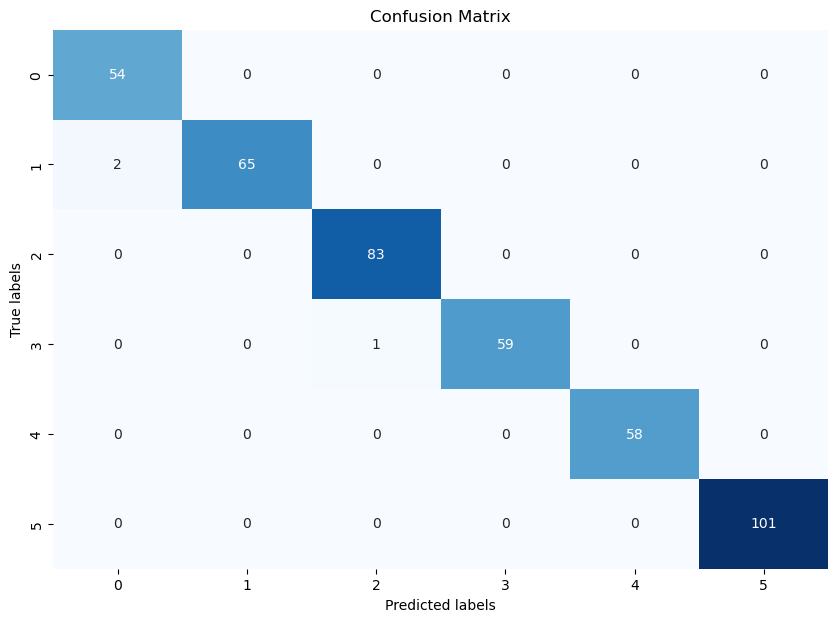

In [25]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_RF, annot=True, fmt="g", cmap='Blues', cbar=False)  # fmt="g" ensures numbers are displayed as integers
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# KNN

The first thing, we're going to need is to determine the value of K; how many neighbors are we going to choose between.
The prediction of multiple classes is quite simple for KNNs, for other ML methods sometimes modeifications are required to handle multiple classes, but here it'll be as simple as just choosing between more potential classes which one class has the majority votes in regards to which one of those classes is closest to the point that we're trying to predict or has a majority vote in the class that we're trying to predict. Note that in multiple classes, choosing a K is preferred to be equal to a multiple of the number of labels (classes), for example a 3 label data we choose some multiples of 3 aka n3 + 1, that + 1 to ensure that one always has the majority vote

In [26]:
knn_clf= KNeighborsClassifier(n_neighbors=10)

In [27]:
model_pipeline_knn= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('clf', knn_clf)
])

In [28]:
model_pipeline_knn.fit(features,target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

In [29]:
# Setting up the KNN Classifier in the pipeline
knn_clf = KNeighborsClassifier()
model_pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', knn_clf)
])

# Iterate over possible n_neighbors values for KNN
for n in [1, 3, 5, 7, 10, 15,20]:
    
    model_pipeline_knn.set_params(clf__n_neighbors=n)  # Setting the n_neighbors value for KNN in the pipeline
    
    model_pipeline_knn.fit(features_train, target_train)
    
    predicted_train = model_pipeline_knn.predict(features_train)
    predicted_test = model_pipeline_knn.predict(features_test)
    
    print('Number of Neighbors:', n)
    
    # Accuracy for training set
    train_accuracy = accuracy_score(target_train, predicted_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    
    # Accuracy for test set
    test_accuracy = accuracy_score(target_test, predicted_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report for test set
    print(classification_report(target_test, predicted_test))
    print('------------------------------------------------')


Number of Neighbors: 1
Train Accuracy: 1.0000
Test Accuracy: 0.8369
                     precision    recall  f1-score   support

Insufficient_Weight       0.75      0.94      0.84        54
      Normal_Weight       0.82      0.55      0.66        67
     Obesity_Type_I       0.84      0.86      0.85        83
    Obesity_Type_II       0.86      0.93      0.90        60
   Obesity_Type_III       1.00      0.95      0.97        58
         Overweight       0.80      0.83      0.82       101

           accuracy                           0.84       423
          macro avg       0.84      0.84      0.84       423
       weighted avg       0.84      0.84      0.83       423

------------------------------------------------
Number of Neighbors: 3
Train Accuracy: 0.9295
Test Accuracy: 0.8487
                     precision    recall  f1-score   support

Insufficient_Weight       0.75      0.94      0.84        54
      Normal_Weight       0.86      0.54      0.66        67
     Obesity_Type_

In [30]:

# Define the path to the KNN model
model_path_knn = "knn_model.pkl"

# Check if the model file exists
if os.path.exists(model_path_knn):
    # Load the model
    with open(model_path_knn, 'rb') as file:
        model_pipeline_knn = pickle.load(file)
    print("KNN Model loaded successfully!")

else:
    # Train the model if it doesn't exist
    model_pipeline_knn.fit(features_train, target_train)
    
    # Save the trained model
    with open(model_path_knn, 'wb') as file:
        pickle.dump(model_pipeline_knn, file)
    print("KNN Model trained and saved successfully!")

# Predict on training data to get training accuracy
train_predictions_knn = model_pipeline_knn.predict(features_train)
train_accuracy_knn = accuracy_score(target_train, train_predictions_knn)
print(f"Training Accuracy: {train_accuracy_knn * 100:.2f}%")

# Predict on test data to get test accuracy
predicted_targets_knn = model_pipeline_knn.predict(features_test)
test_accuracy_knn = accuracy_score(target_test, predicted_targets_knn)
print(f"Test Accuracy: {test_accuracy_knn * 100:.2f}%")

# Get the classification report
report_knn = classification_report(target_test, predicted_targets_knn)
print("Classification Report:")
print(report_knn)

# Get the confusion matrix
conf_matrix_knn = confusion_matrix(target_test, predicted_targets_knn)
print("\nConfusion Matrix:")
print(conf_matrix_knn)



KNN Model loaded successfully!
Training Accuracy: 85.37%
Test Accuracy: 80.38%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.75      0.96      0.85        54
      Normal_Weight       0.82      0.40      0.54        67
     Obesity_Type_I       0.82      0.84      0.83        83
    Obesity_Type_II       0.77      0.93      0.84        60
   Obesity_Type_III       0.96      0.86      0.91        58
         Overweight       0.77      0.84      0.80       101

           accuracy                           0.80       423
          macro avg       0.81      0.81      0.80       423
       weighted avg       0.81      0.80      0.79       423


Confusion Matrix:
[[52  2  0  0  0  0]
 [16 27  2  0  0 22]
 [ 0  0 70  9  0  4]
 [ 0  0  2 56  2  0]
 [ 0  0  0  8 50  0]
 [ 1  4 11  0  0 85]]


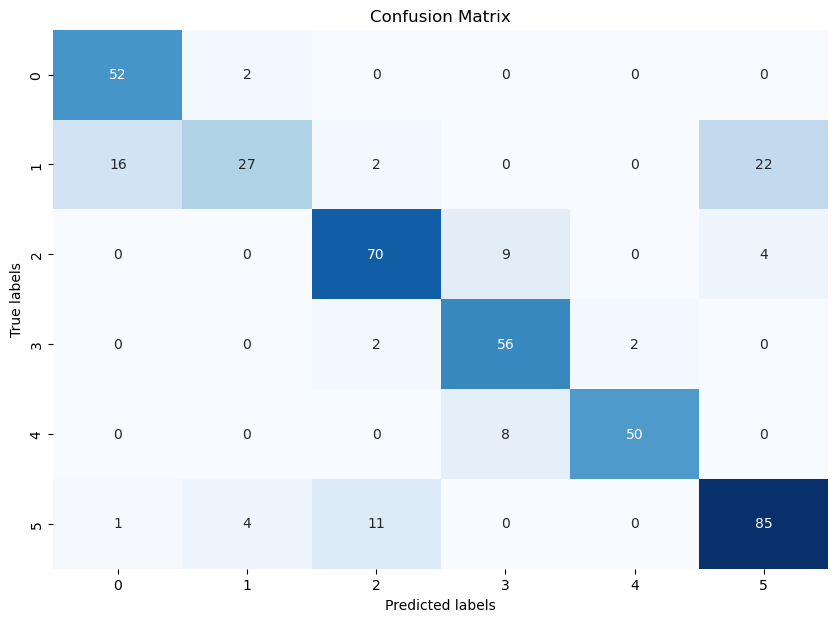

In [31]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_knn, annot=True, fmt="g", cmap='Blues', cbar=False)  # fmt="g" ensures numbers are displayed as integers
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:

# Initialize K-Fold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Setting up the KNN Classifier in the pipeline
knn_clf = KNeighborsClassifier(n_neighbors=15)
model_pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', knn_clf)
])

train_accuracies = []
test_accuracies = []

for fold_num, (train_index, test_index) in enumerate(kf.split(features), 1):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    # Define model path for current fold
    model_path_knn = f"knn_model_fold_{fold_num}.pkl"
    
    # Check if the model file for the current fold exists
    if os.path.exists(model_path_knn):
        # Load the model
        with open(model_path_knn, 'rb') as file:
            model_pipeline_knn = pickle.load(file)
        print(f"KNN Model for fold {fold_num} loaded successfully!")

    else:
        # Train the model if it doesn't exist for the current fold
        model_pipeline_knn.fit(X_train, y_train)
        
        # Save the trained model for the current fold
        with open(model_path_knn, 'wb') as file:
            pickle.dump(model_pipeline_knn, file)
        print(f"KNN Model for fold {fold_num} trained and saved successfully!")

    # Predict on training data from the current fold
    train_predictions = model_pipeline_knn.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_accuracies.append(train_accuracy)

    # Predict on test data from the current fold
    test_predictions = model_pipeline_knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_accuracies.append(test_accuracy)
    
    # Display results for the current fold
    print(f"Fold {fold_num}")
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Classification Report:")
    print(classification_report(y_test, test_predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, test_predictions))
    print('------------------------------------------------')

# Display average results across all folds
print(f"Average Training Accuracy: {np.mean(train_accuracies) * 100:.2f}%")
print(f"Average Test Accuracy: {np.mean(test_accuracies) * 100:.2f}%")









KNN Model for fold 1 loaded successfully!
Fold 1
Training Accuracy: 0.8678909952606635
Test Accuracy: 0.8108747044917257
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.75      0.93      0.83        54
      Normal_Weight       0.77      0.45      0.57        67
     Obesity_Type_I       0.84      0.84      0.84        83
    Obesity_Type_II       0.81      0.92      0.86        60
   Obesity_Type_III       0.96      0.88      0.92        58
         Overweight       0.77      0.86      0.81       101

           accuracy                           0.81       423
          macro avg       0.82      0.81      0.80       423
       weighted avg       0.81      0.81      0.80       423

Confusion Matrix:
[[50  3  0  0  0  1]
 [17 30  2  0  0 18]
 [ 0  0 70  6  0  7]
 [ 0  0  3 55  2  0]
 [ 0  0  0  7 51  0]
 [ 0  6  8  0  0 87]]
------------------------------------------------
KNN Model for fold 2 loaded successfully!
Fold 2


# Support Vector Machines SVM

SVM are linear classifier that won't return probabilities, but they'll return labels , and those labels are decided by which size of a certain decision boundary they fall on, that decision boundary was initially found by determining the hyperplane or line that minimize errors, as well as finding the widest margin between classes. 

In [33]:

LSVC_clf = LinearSVC(C=100)


In [34]:
model_pipeline_LSVC= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('clf', LSVC_clf)
])

In [35]:
model_pipeline_LSVC.fit(features, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf', LinearSVC(C=100))])

In [36]:


# Iterate over possible C values for the SVC
for C_value in [0.1, 1,2,3,10,100]:
    
    # Setting the C value for the SVC in the pipeline
    
    model_pipeline_LSVC.set_params(clf__C=C_value)
    # Fit the model using training data
  
    model_pipeline_LSVC.fit(features_train, target_train)
    # Predictions for training and test set
    predicted_train = model_pipeline_LSVC.predict(features_train)
    
    predicted_test = model_pipeline_LSVC.predict(features_test)
    
    print('C Value:', C_value)
    
    # Accuracy for training set
    train_accuracy = accuracy_score(target_train, predicted_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    
    # Accuracy for test set
    test_accuracy = accuracy_score(target_test, predicted_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report for test set
    print(classification_report(target_test, predicted_test))
    print('------------------------------------------------')


C Value: 0.1
Train Accuracy: 0.7672
Test Accuracy: 0.7352
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.98      0.91        54
      Normal_Weight       0.74      0.46      0.57        67
     Obesity_Type_I       0.71      0.42      0.53        83
    Obesity_Type_II       0.75      0.92      0.83        60
   Obesity_Type_III       0.97      1.00      0.98        58
         Overweight       0.58      0.78      0.66       101

           accuracy                           0.74       423
          macro avg       0.77      0.76      0.75       423
       weighted avg       0.74      0.74      0.72       423

------------------------------------------------
C Value: 1
Train Accuracy: 0.7773
Test Accuracy: 0.7400
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      1.00      0.94        54
      Normal_Weight       0.74      0.48      0.58        67
     Obesity_Type_I       0.71      0.42

In [37]:


# Define the path to your model
model_path_LSVC = "linear_svc_model.pkl"

# Check if the model file exists
if os.path.exists(model_path_LSVC):
    # Load the model
    with open(model_path_LSVC, 'rb') as file:
        model_pipeline_LSVC = pickle.load(file)
    print("LSVC model loaded successfully!")
else:
    # Train the model if it doesn't exist
    model_pipeline_LSVC.fit(features_train, target_train)

    # Save the trained model
    with open(model_path_LSVC, 'wb') as file:
        pickle.dump(model_pipeline_LSVC, file)
    print("LSVC model trained and saved successfully!")

# Predict on training data to get training accuracy
train_predictions = model_pipeline_LSVC.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Predict on test data to get test accuracy
predicted_targets_svm = model_pipeline_LSVC.predict(features_test)
test_accuracy_svm = accuracy_score(target_test, predicted_targets_svm)
print(f"Test Accuracy: {test_accuracy_svm * 100:.2f}%")

# Get the classification report
report = classification_report(target_test, predicted_targets_svm)
print("Classification Report:")
print(report)

# Get the confusion matrix
conf_matrix_LSVC = confusion_matrix(target_test, predicted_targets_svm)
print("\nConfusion Matrix:")
print(conf_matrix_LSVC)



LSVC model loaded successfully!
Training Accuracy: 66.82%
Test Accuracy: 68.09%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.94      0.94        54
      Normal_Weight       0.41      0.79      0.54        67
     Obesity_Type_I       0.91      0.25      0.40        83
    Obesity_Type_II       0.71      0.95      0.81        60
   Obesity_Type_III       1.00      1.00      1.00        58
         Overweight       0.61      0.48      0.53       101

           accuracy                           0.68       423
          macro avg       0.76      0.74      0.70       423
       weighted avg       0.75      0.68      0.66       423


Confusion Matrix:
[[51  3  0  0  0  0]
 [ 4 53  0  0  0 10]
 [ 0 20 21 21  0 21]
 [ 0  2  1 57  0  0]
 [ 0  0  0  0 58  0]
 [ 0 50  1  2  0 48]]


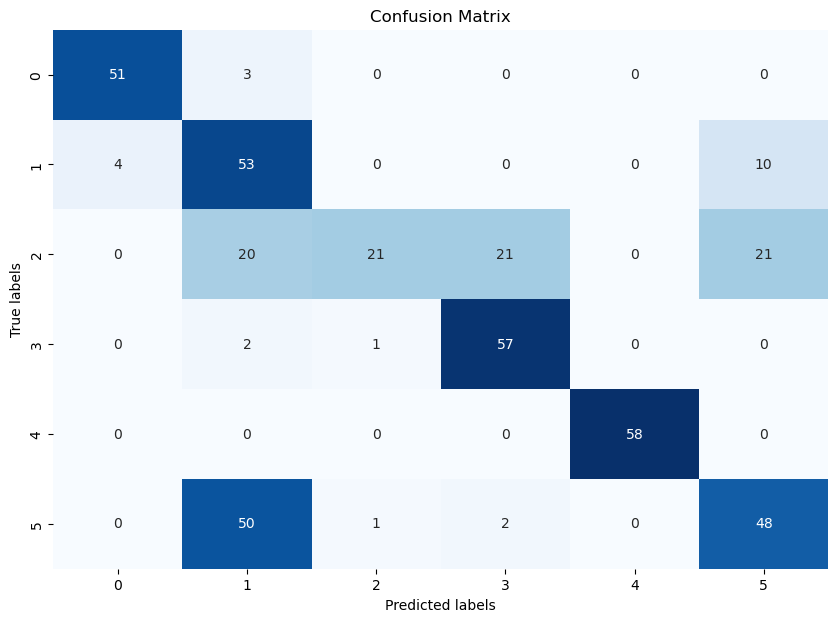

In [38]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_LSVC, annot=True, fmt="g", cmap='Blues', cbar=False)  # fmt="g" ensures numbers are displayed as integers
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# AdaBoost

AdaBoost, which stands for "Adaptive Boosting", is an ensemble machine learning algorithm predominantly used for classification tasks, though it can be adapted for regression. AdaBoost is an ensemble method of the boosting type, meaning that it constructs a series of weak learners, typically decision trees, sequentially, with each tree attempting to correct the errors of its predecessor.

In [39]:
# Creating a pipeline for AdaBoost
model_pipeline_ada = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', AdaBoostClassifier(n_estimators=10, learning_rate=0.01))
])


In [40]:
# Fit the model using training data
model_pipeline_ada.fit(features_train, target_train)
        

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf',
                 AdaBoostClassifier(learning_rate=0.01, n_estimators=10))])

In [41]:
# Define values for n_estimators and learning_rate to iterate over
n_estimators_values = [10, 50, 100]
learning_rates = [0.01, 0.05, 0.1]

for n_trees in n_estimators_values:
    for lr in learning_rates:
        
        # Setting the n_estimators and learning_rate for the AdaBoost in the pipeline
        model_pipeline_ada.set_params(clf__n_estimators=n_trees, clf__learning_rate=lr)
        
        
        # Predictions for training and test set
        predicted_train = model_pipeline_ada.predict(features_train)
        predicted_test = model_pipeline_ada.predict(features_test)
        
        print('Number of Trees:', n_trees)
        print('Learning Rate:', lr)
        
        # Accuracy for training set
        train_accuracy = accuracy_score(target_train, predicted_train)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        
        # Accuracy for test set
        test_accuracy = accuracy_score(target_test, predicted_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Classification report for test set
        print(classification_report(target_test, predicted_test))
        print('------------------------------------------------')


Number of Trees: 10
Learning Rate: 0.01
Train Accuracy: 0.4443
Test Accuracy: 0.4350
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00        54
      Normal_Weight       0.00      0.00      0.00        67
     Obesity_Type_I       0.41      1.00      0.58        83
    Obesity_Type_II       0.00      0.00      0.00        60
   Obesity_Type_III       0.00      0.00      0.00        58
         Overweight       0.45      1.00      0.63       101

           accuracy                           0.43       423
          macro avg       0.14      0.33      0.20       423
       weighted avg       0.19      0.43      0.26       423

------------------------------------------------
Number of Trees: 10
Learning Rate: 0.05
Train Accuracy: 0.4443
Test Accuracy: 0.4350
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00        54
      Normal_Weight       0.00      0.00     

In [42]:

# Define the path to your AdaBoost model
model_path_ada = "adaboost_model.pkl"

# Check if the model file exists
if os.path.exists(model_path_ada):
    # Load the model
    with open(model_path_ada, 'rb') as file:
        model_pipeline_ada = pickle.load(file)
    print("AdaBoost model loaded successfully!")
else:
    # Define a pipeline for AdaBoost
    model_pipeline_ada = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier(n_estimators=10, learning_rate=0.01))
    ])
    
    # Setting the n_estimators and learning_rate for the AdaBoost in the pipeline
    model_pipeline_ada.set_params(clf__n_estimators=10, clf__learning_rate=0.01)

    # Train the model
    model_pipeline_ada.fit(features_train, target_train)

    # Save the trained model
    with open(model_path_ada, 'wb') as file:
        pickle.dump(model_pipeline_ada, file)
    print("AdaBoost model trained and saved successfully!")

# Predict on training data to get training accuracy
train_predictions_ada = model_pipeline_ada.predict(features_train)
train_accuracy_ada = accuracy_score(target_train, train_predictions_ada)
print(f"Training Accuracy: {train_accuracy_ada * 100:.2f}%")

# Predict on test data to get test accuracy
predicted_targets_ada = model_pipeline_ada.predict(features_test)
test_accuracy_ada = accuracy_score(target_test, predicted_targets_ada)
print(f"Test Accuracy: {test_accuracy_ada * 100:.2f}%")

# Get the classification report
report_ada = classification_report(target_test, predicted_targets_ada)
print("Classification Report:")
print(report_ada)


AdaBoost model loaded successfully!
Training Accuracy: 44.43%
Test Accuracy: 43.50%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00        54
      Normal_Weight       0.00      0.00      0.00        67
     Obesity_Type_I       0.41      1.00      0.58        83
    Obesity_Type_II       0.00      0.00      0.00        60
   Obesity_Type_III       0.00      0.00      0.00        58
         Overweight       0.45      1.00      0.63       101

           accuracy                           0.43       423
          macro avg       0.14      0.33      0.20       423
       weighted avg       0.19      0.43      0.26       423



In [43]:
#k-fold

In [44]:

# Define values for n_estimators and learning_rate to iterate over
n_estimators_values = [10, 50, 100]
learning_rates = [0.01, 0.05, 0.1]

for n_trees in n_estimators_values:
    for lr in learning_rates:
        
        # Setting the n_estimators and learning_rate for the AdaBoost in the pipeline
        model_pipeline_ada.set_params(clf__n_estimators=n_trees, clf__learning_rate=lr)
        
        # Applying 10-fold cross-validation
        cv_scores = cross_val_score(model_pipeline_ada, features_train, target_train, cv=10)
        
        print('Number of Trees:', n_trees)
        print('Learning Rate:', lr)
        
        # Display average of the 10-fold CV scores
        print(f"10-Fold CV Accuracy: {cv_scores.mean():.4f}")
        print(f"Standard Deviation of CV scores: {cv_scores.std():.4f}")
        
        # If you still want to fit the model and predict on the test set:
        model_pipeline_ada.fit(features_train, target_train)
        predicted_test = model_pipeline_ada.predict(features_test)
        
        # Accuracy for test set
        test_accuracy = accuracy_score(target_test, predicted_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Classification report for test set
        print(classification_report(target_test, predicted_test))
        print('------------------------------------------------')



Number of Trees: 10
Learning Rate: 0.01
10-Fold CV Accuracy: 0.4443
Standard Deviation of CV scores: 0.0057
Test Accuracy: 0.4350
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00        54
      Normal_Weight       0.00      0.00      0.00        67
     Obesity_Type_I       0.41      1.00      0.58        83
    Obesity_Type_II       0.00      0.00      0.00        60
   Obesity_Type_III       0.00      0.00      0.00        58
         Overweight       0.45      1.00      0.63       101

           accuracy                           0.43       423
          macro avg       0.14      0.33      0.20       423
       weighted avg       0.19      0.43      0.26       423

------------------------------------------------
Number of Trees: 10
Learning Rate: 0.05
10-Fold CV Accuracy: 0.4443
Standard Deviation of CV scores: 0.0057
Test Accuracy: 0.4350
                     precision    recall  f1-score   support

Insufficient_Wei

In [45]:


# Define the path to your AdaBoost model
model_path_ada = "kfold_adaboost_model.pkl"

n_trees = 50
lr = 0.05

# Check if the model file exists
if os.path.exists(model_path_ada):
    # Load the model
    with open(model_path_ada, 'rb') as file:
        model_pipeline_ada = pickle.load(file)
    print("AdaBoost model loaded successfully!")
else:
    # Define a pipeline for AdaBoost
    model_pipeline_ada = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier(random_state=42))
    ])
    
    # Setting the n_estimators and learning_rate for the AdaBoost in the pipeline
    model_pipeline_ada.set_params(clf__n_estimators=n_trees, clf__learning_rate=lr)
    
    # Applying 10-fold cross-validation
    cv_scores = cross_val_score(model_pipeline_ada, features_train, target_train, cv=10)
    
    print('Number of Trees:', n_trees)
    print('Learning Rate:', lr)
    print(f"10-Fold CV Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of CV scores: {cv_scores.std():.4f}")
    
    # Train the model
    model_pipeline_ada.fit(features_train, target_train)

    # Save the trained model
    with open(model_path_ada, 'wb') as file:
        pickle.dump(model_pipeline_ada, file)
    print("AdaBoost model trained and saved successfully!")

# If you still want to predict on the test set:
predicted_test = model_pipeline_ada.predict(features_test)

# Accuracy for test set
test_accuracy = accuracy_score(target_test, predicted_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report for test set
print(classification_report(target_test, predicted_test))
print('------------------------------------------------')


AdaBoost model loaded successfully!
Test Accuracy: 0.7352
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00        54
      Normal_Weight       0.55      1.00      0.71        67
     Obesity_Type_I       1.00      1.00      1.00        83
    Obesity_Type_II       0.51      1.00      0.67        60
   Obesity_Type_III       0.00      0.00      0.00        58
         Overweight       1.00      1.00      1.00       101

           accuracy                           0.74       423
          macro avg       0.51      0.67      0.56       423
       weighted avg       0.59      0.74      0.64       423

------------------------------------------------


# Voting Classifer

The Voting Classifier is not a standalone model, but rather an ensemble meta-estimator. It's used to combine conceptually different machine learning classifiers and utilize a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well-performing models in order to balance out their individual weaknesses.

In [46]:


# Define the path to your model
model_path_voting = "voting_clf_model.pkl"

# Define the individual models
rf_clf = RandomForestClassifier(n_estimators=50)
gb_clf = GradientBoostingClassifier(n_estimators=50)
svc_clf = SVC(probability=True, kernel='linear')

# Create a VotingClassifier with the individual models
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('svc', svc_clf)],
    voting='soft'  # Use 'hard' for hard voting and 'soft' for soft voting
)

# Create a pipeline
model_pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', voting_clf)
])

# Check if the model file exists
if os.path.exists(model_path_voting):
    # Load the model
    with open(model_path_voting, 'rb') as file:
        model_pipeline_voting = pickle.load(file)
    print("Voting classifier model loaded successfully!")
else:
    # Train the model if it doesn't exist
    model_pipeline_voting.fit(features_train, target_train)

    # Save the trained model
    with open(model_path_voting, 'wb') as file:
        pickle.dump(model_pipeline_voting, file)
    print("Voting classifier model trained and saved successfully!")

# Predictions for training and test set
predicted_train = model_pipeline_voting.predict(features_train)
predicted_test = model_pipeline_voting.predict(features_test)

# Accuracy for training set
train_accuracy = accuracy_score(target_train, predicted_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Accuracy for test set
test_accuracy = accuracy_score(target_test, predicted_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report for test set
print(classification_report(target_test, predicted_test))





Voting classifier model loaded successfully!
Train Accuracy: 1.0000
Test Accuracy: 0.9976
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        54
      Normal_Weight       1.00      1.00      1.00        67
     Obesity_Type_I       0.99      1.00      0.99        83
    Obesity_Type_II       1.00      0.98      0.99        60
   Obesity_Type_III       1.00      1.00      1.00        58
         Overweight       1.00      1.00      1.00       101

           accuracy                           1.00       423
          macro avg       1.00      1.00      1.00       423
       weighted avg       1.00      1.00      1.00       423



In [47]:
# Load the saved model
with open("random_forest_model.pkl", 'rb') as file:
    model_pipeline_RF = pickle.load(file)
#function for user input 
def collect_user_input():
    # Asking user for each specific input
    gender = input("Please enter Gender (Female/Male): ")
    age = float(input("Please enter your Age: "))
    height = float(input("Please enter your Height in m between 1 to 2: "))
    weight = float(input("Please enter your Weight: "))
    family_history = input("Please enter family history with overweight (yes/no): ")
    favc = input("Please enter FAVC (yes/no): ")
    caec = input("Please enter CAEC (no/Sometimes/Frequently/Always): ")
    smoke = input("Please enter SMOKE (yes/no): ")
    scc = input("Please enter SCC (yes/no): ")
    calc = input("Please enter CALC (no/Sometimes/Frequently/Always): ")
    mtrans = input("Please enter MTRANS (Automobile/Bike/Motorbike/Public Transportation/Walking): ")
    bmi = float(input("Please enter your BMI: "))
    NCP = int(input("Please enter how many main meals do you have daily (NCP) [1,2,3,4]: "))
    FCVC = input("Frequency of consumption of vegetables (FCVC) enter 1 for Never /2 for Sometimes and 3 for Always: ")
    CH2O = input("Please enter how much water do you drink daily (CH2O) enter 1 for less than a liter, 2 for between 1 and 2 and 3 for more than 2]: ")
    TUE = input("How much time do you use technological devices enter 1 for 0-2 h , 2 for 3-5 h and 3 for more than 5 ")
    FAF = input("How often do you have physical activity enter 0 for I do not have, 1 for 1 or 2 days, 2 for 3 or 4 days and 3 for 4 or 5 days")
    # Create a dictionary with the collected data
    user_data = {
        'Gender': [gender], 'Age': [age], 'Height': [height], 'Weight': [weight], 'family_history_with_overweight': [family_history],
        'FAVC': [favc], 'CAEC': [caec], 'SMOKE': [smoke], 'SCC': [scc], 'CALC': [calc],
        'MTRANS': [mtrans], 'BMI': [bmi], 'NCP': [NCP], 'FCVC': [FCVC], 
        'CH2O': [CH2O], 'TUE': [TUE], 'FAF': [FAF]
    }
    # Convert the dictionary to a DataFrame
    user_df = pd.DataFrame(user_data)
    return user_df
# Now call the function to collect the input from the user
user_input_df = collect_user_input()
predictions = model_pipeline_RF.predict(user_input_df)
print(predictions)



Please enter Gender (Female/Male): Female
Please enter your Age: 38
Please enter your Height in m between 1 to 2: 1.67
Please enter your Weight: 65
Please enter family history with overweight (yes/no): yes
Please enter FAVC (yes/no): no
Please enter CAEC (no/Sometimes/Frequently/Always): no
Please enter SMOKE (yes/no): no
Please enter SCC (yes/no): no
Please enter CALC (no/Sometimes/Frequently/Always): no
Please enter MTRANS (Automobile/Bike/Motorbike/Public Transportation/Walking): Automobile
Please enter your BMI: 23
Please enter how many main meals do you have daily (NCP) [1,2,3,4]: 1
Frequency of consumption of vegetables (FCVC) enter 1 for Never /2 for Sometimes and 3 for Always: 2
Please enter how much water do you drink daily (CH2O) enter 1 for less than a liter, 2 for between 1 and 2 and 3 for more than 2]: 1
How much time do you use technological devices enter 1 for 0-2 h , 2 for 3-5 h and 3 for more than 5 2
How often do you have physical activity enter 0 for I do not have, 1

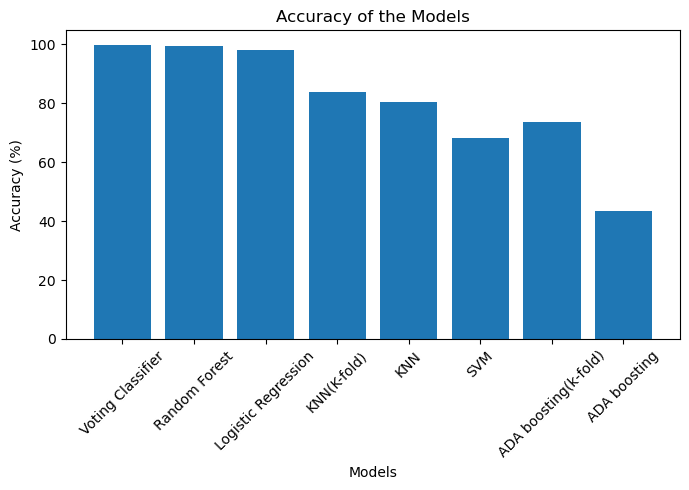

In [49]:

# Define model names and their accuracies
models = ['Voting Classifier', 'Random Forest','Logistic Regression','KNN(K-fold)','KNN', 'SVM', 'ADA boosting(k-fold)','ADA boosting']
accuracies = [99.76, 99.29, 98.11, 83.94, 80.38, 68.09, 73.52, 43.50]   
# Plotting
plt.figure(figsize=(7, 5))
plt.bar(models, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of the Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
